<a href="https://colab.research.google.com/github/BilaArta/Sentiment-Classification/blob/main/Sentiment_Analysis_metric_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import pandas as pd
import string
import re
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

In [2]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
# Run this to ensure TensorFlow 2.x is used
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

**Create Shared Drive to Load Datasets**

In [ ]:
url = "https://drive.google.com/file/d/1-0Toq9QRcnWDSEedEsM-xgx7IsDD-34P/view?usp=sharing"
id = url.split('/')[5].split('?')[0]
id

'1-0Toq9QRcnWDSEedEsM-xgx7IsDD-34P'

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': id})   # replace the id with id of file you want to access
downloaded.GetContentFile('datasets.csv')        # replace the file name with your file

**Load Datasets From Own Drive**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!ls "/content/drive/My Drive/Google Colab TA NLP/Dataset/"

datasets.csv  reviews_hotel_0_50.csv  reviews_hotel_50_150.csv


In [12]:
df_data = pd.read_csv('/content/drive/My Drive/Google Colab TA NLP/Dataset/datasets.csv')
df_data.head()

,Unnamed: 0,user_url,user_name,url_hotel,total_reviews,Date,Rating,Title,Review,sentiment
0,0,/Profile/SanGrya,SanGrya,/Hotel_Review-g297700-d5511134-Reviews-Kejora_...,30,Date of stay: September 2019,50,Peaceful hotel with great breakfast next door,We really thought this hotel was lovely. It’s ...,2
1,1,/Profile/duncanworldtraveller,Duncan B,/Hotel_Review-g297700-d5511134-Reviews-Kejora_...,18,Date of stay: March 2020,50,Awesome place to stay,Great service from check in to check out. Clea...,2
2,2,/Profile/brigitte1960,brigitte1960,/Hotel_Review-g297700-d5511134-Reviews-Kejora_...,589,Date of stay: February 2020,50,Warm welcome home,Stayed 6 nights inKejora. upstairs room. Nice...,2
3,3,/Profile/BundyRed,BundyRed,/Hotel_Review-g297700-d5511134-Reviews-Kejora_...,2928,Date of stay: February 2020,50,Quiet and relaxing,Spent a couple of nites here last week and we ...,2
4,4,/Profile/sniemira,sniemira,/Hotel_Review-g297700-d5511134-Reviews-Kejora_...,99,Date of stay: January 2020,50,second time here and still love it,My husband and I spent a couple of nights here...,2


In [13]:
def divide_data(df_data, length=5000) :
  df_negatif = df_data[df_data['sentiment'] == 0]
  df_netral = df_data[df_data['sentiment'] == 1]
  df_positif = df_data[df_data['sentiment'] == 2]

  datasets = [df_negatif.iloc[:length], df_netral.iloc[:length], df_positif.iloc[:length]]
  datasets = pd.concat(datasets)

  return datasets.sample(frac = 1)

In [14]:
df_data = divide_data(df_data)
df_data

,Unnamed: 0,user_url,user_name,url_hotel,total_reviews,Date,Rating,Title,Review,sentiment
41889,41889,/Profile/philipotti,Phil S,/Hotel_Review-g608487-d309333-Reviews-Puri_Wis...,51,Date of stay: December 2016,10,A total DUMP and I'm not joking!,The title doesn't give it justice of how terri...,0
37533,37533,/Profile/leewky2002,leewky2002,/Hotel_Review-g1380108-d4723700-Reviews-Lorin_...,46,Date of stay: January 2014,10,"Anything the worse and come to a ""Ghost Hotel""","I stayed this hotel on 1 to 2- Jan-2014,this h...",0
29429,29429,/Profile/AlexandraM241,AlexandraM241,/Hotel_Review-g297697-d5518950-Reviews-Putri_H...,350,Date of stay: April 2015,30,"Room nice, service average.",We stayed here for 6 nights. The room is lovel...,1
15521,15521,/Profile/105rossl,Ross L,/Hotel_Review-g297700-d7353471-Reviews-Nesa_Sa...,122,Date of stay: January 2020,20,Disappointing,I am afraid that this is a hotel I simply cann...,0
20947,20947,/Profile/792gerdab,Gerda B,/Hotel_Review-g297700-d307573-Reviews-Parigata...,1,Date of stay: July 2018,20,Absolutely not even 3 star,Mattrasses were very hard and did not fit the ...,0
...,...,...,...,...,...,...,...,...,...,...
28040,28040,/Profile/ronniw883,Ronni W,/Hotel_Review-g297697-d4885511-Reviews-Nakula_...,2,Date of stay: May 2014,30,Restful sleep,It's not near main street but overall they giv...,1
46255,46255,/Profile/sandyii723,sandyii723,/Hotel_Review-g297701-d8835460-Reviews-Suarsen...,41,Date of stay: January 2016,30,Had a bad sleep for the first night in Ubud an...,I arrived early that morning and walked around...,1
37841,37841,/Profile/Tvlwkdz,Tvlwkdz,/Hotel_Review-g297697-d1944623-Reviews-Mahagir...,83,Date of stay: September 2016,30,Excellent view but touristic,We just wanted a quick bite and feed our littl...,1
18077,18077,/Profile/andrefrans,andrichhh,/Hotel_Review-g297701-d5986602-Reviews-Black_P...,1,Date of stay: August 2020,10,Terrible,"i have booked two rooms, upon arrived there is...",0


Remove punctuation

In [15]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [16]:
def get_sentences_labels(df) :
  sentences = []
  labels = []

  for index, row in df.iterrows():
      sentences.append(row['Review'])
      labels.append(row['sentiment'])
      
  return sentences, labels

In [17]:
def label_encoder(Y):
  encoder = LabelEncoder()
  encoder.fit(Y)
  encoded_Y = encoder.transform(Y)

  # convert integers to dummy variables (i.e. one hot encoded)
  labels = np_utils.to_categorical(encoded_Y)
  return labels

In [18]:
def split_data(datasets, labels, split=0.7):
  training_size = int(len(datasets)* split)

  X_train = datasets[0:training_size]
  X_test = datasets[training_size:]
  Y_train = labels[0:training_size]
  Y_test = labels[training_size:]
  return X_train, X_test, Y_train, Y_test

In [19]:
def get_lemmatized_text(corpus):
    
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

# lemmatized_reviews = get_lemmatized_text(reviews_train_clean)

In [20]:
def Tokenization(training_sentences, testing_sentences, vocab_size=10000, oov_tok="<OOV>",max_length = 120,
                 trunc_type='post', padding_type='post') :
  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(training_sentences)

  word_index = tokenizer.word_index

  training_sequences = tokenizer.texts_to_sequences(training_sentences)
  training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return word_index, training_padded, testing_padded

In [21]:
df_data['Review'] = [deEmojify(re.sub(r'[^\w\s]','', w.lower())) for w in df_data['Review']]
df_data['Review']

41889    the title doesnt give it justice of how terrib...
37533    i stayed this hotel on 1 to 2 jan2014this hote...
29429    we stayed here for 6 nights the room is lovely...
15521    i am afraid that this is a hotel i simply cann...
20947    mattrasses were very hard and did not fit the ...
                               ...                        
28040    its not near main street but overall they give...
46255    i arrived early that morning and walked around...
37841    we just wanted a quick bite and feed our littl...
18077    i have booked two rooms upon arrived there is ...
3551     villa was a bit too old  hot water cant fill u...
Name: Review, Length: 15000, dtype: object

In [22]:
stop_words=['in','of','at','a','the', 'is', 'it', 'i', 'we', 'and', 'they', 'were', 'are']

In [23]:
stop_words = stopwords.words('english')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [24]:
remove_words = ["was", "have", "has", "had", "do", "does", "did", "during", "above", "below", "to", "from", "more", "most", "no",
                   "not", "only", "own", "too", "very", "t", "can", "dont", "don't", "should", "should've", "ve", "ain", "aren",
                   "aren't", "couldn", "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", "hasn", "hasn't", "haven", "haven't",
                   "mustn", "mustn't", "needn", "needn't", "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", "won't", "wouldn",
                   "wouldn't"]
stop_words = [x for x in stop_words if x not in remove_words]

In [25]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'were',
 'be',
 'been',
 'being',
 'having',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'before',
 'after',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'other',
 'some',
 'such',
 'nor',
 'same',
 'so',
 'than',
 's',
 'will',
 'just',
 'don',


In [26]:
reviews, labels = get_sentences_labels(df_data)

In [27]:
labels = label_encoder(labels)

In [28]:
lemmatized_reviews = get_lemmatized_text(reviews)
lemmatized_reviews[0]

'the title doesnt give it justice of how terrible this place really iswe arrived where they advised u that the room wa two single which didnt go down well to start we then proceeded to taken to a mouldy hot smelling room where we then asked to see another room a my wife wa pregnant and the smell wa unbearable and certainly unhealthy for u both after a discussion on health they then said we could see a double room even after saying there werent anythat room wa worse mould damp stain terrible bathroom and again a damp smell third time lucky i think not again same thing but better thank the others until we found the sink full of cockroach coming from the plug blood stained sheet etc etcwe lefta full refund wa given after a lengthy argument and no hotel manager to speak with a they were out the countryi wouldnt stay there even if i wa a poor student it also located on a very busy road so expect noise through the night and expect a warm night the air con isnt worth using'

In [29]:
lemmatized_sentences = []
for sentence in lemmatized_reviews :
  sentence = sentence.split()
  filtered_sentence = [w for w in sentence if not w in stop_words]
  lemmatized_sentences.append(filtered_sentence)
lemmatized_sentences

[['title',
  'doesnt',
  'give',
  'justice',
  'terrible',
  'place',
  'really',
  'iswe',
  'arrived',
  'advised',
  'u',
  'room',
  'wa',
  'two',
  'single',
  'didnt',
  'go',
  'well',
  'to',
  'start',
  'proceeded',
  'to',
  'taken',
  'to',
  'mouldy',
  'hot',
  'smelling',
  'room',
  'asked',
  'to',
  'see',
  'another',
  'room',
  'wife',
  'wa',
  'pregnant',
  'smell',
  'wa',
  'unbearable',
  'certainly',
  'unhealthy',
  'u',
  'discussion',
  'health',
  'said',
  'could',
  'see',
  'double',
  'room',
  'even',
  'saying',
  'werent',
  'anythat',
  'room',
  'wa',
  'worse',
  'mould',
  'damp',
  'stain',
  'terrible',
  'bathroom',
  'damp',
  'smell',
  'third',
  'time',
  'lucky',
  'think',
  'not',
  'thing',
  'better',
  'thank',
  'others',
  'found',
  'sink',
  'full',
  'cockroach',
  'coming',
  'from',
  'plug',
  'blood',
  'stained',
  'sheet',
  'etc',
  'etcwe',
  'lefta',
  'full',
  'refund',
  'wa',
  'given',
  'lengthy',
  'argument'

In [30]:
clear_sentences = [" ".join(s) for s in lemmatized_sentences]
clear_sentences

['title doesnt give justice terrible place really iswe arrived advised u room wa two single didnt go well to start proceeded to taken to mouldy hot smelling room asked to see another room wife wa pregnant smell wa unbearable certainly unhealthy u discussion health said could see double room even saying werent anythat room wa worse mould damp stain terrible bathroom damp smell third time lucky think not thing better thank others found sink full cockroach coming from plug blood stained sheet etc etcwe lefta full refund wa given lengthy argument no hotel manager to speak countryi wouldnt stay even wa poor student also located very busy road expect noise night expect warm night air con isnt worth using',
 'stayed hotel 1 to 2 jan2014this hotel have many problem belowi dont never see beforei cant give star hotel1 no safetydeposit box2 no hot water only one tap wash3 no door wash area water to splash4 window have noise sound wind5 light poor room 6 bedspillows quilted cover not clean had man

In [31]:
x_train, x_test, y_train, y_test = split_data(clear_sentences, labels)

In [32]:
vocab_size = 10000
embedding_dim = 300
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [33]:
word_index, x_train, x_test = Tokenization(x_train, x_test, vocab_size=vocab_size, max_length=max_length)

In [34]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [35]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(10500, 120)
(10500, 3)
(4500, 120)
(4500, 3)


In [36]:
x_train

array([[2977,  364,  222, ...,  300,  616,    0],
       [  29,    6,  139, ...,    0,    0,    0],
       [  29,  348,   17, ..., 1091,  407,   39],
       ...,
       [  29,  800,   64, ...,  121,   52,    0],
       [  18,  525,    7, ...,    0,    0,    0],
       [ 939,   29,   44, ...,    5,   60,  136]], dtype=int32)

In [37]:
y_train

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

ANN Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 300)          3000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               30100     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 3,030,403
Trainable params: 3,030,403
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model.fit(x_train, y_train, epochs=num_epochs, verbose=2)

Epoch 1/50
1397/1397 - 8s - loss: 0.6827 - accuracy: 0.7814
Epoch 2/50
1397/1397 - 8s - loss: 0.6603 - accuracy: 0.7821
Epoch 3/50
1397/1397 - 7s - loss: 0.6595 - accuracy: 0.7821
Epoch 4/50
1397/1397 - 7s - loss: 0.6588 - accuracy: 0.7821
Epoch 5/50
1397/1397 - 8s - loss: 0.6582 - accuracy: 0.7821
Epoch 6/50
1397/1397 - 8s - loss: 0.6576 - accuracy: 0.7821
Epoch 7/50
1397/1397 - 8s - loss: 0.6569 - accuracy: 0.7821
Epoch 8/50
1397/1397 - 8s - loss: 0.6563 - accuracy: 0.7821
Epoch 9/50
1397/1397 - 8s - loss: 0.6555 - accuracy: 0.7821
Epoch 10/50
1397/1397 - 8s - loss: 0.6545 - accuracy: 0.7821
Epoch 11/50
1397/1397 - 8s - loss: 0.6534 - accuracy: 0.7821
Epoch 12/50
1397/1397 - 8s - loss: 0.6521 - accuracy: 0.7821
Epoch 13/50
1397/1397 - 7s - loss: 0.6505 - accuracy: 0.7821
Epoch 14/50
1397/1397 - 8s - loss: 0.6485 - accuracy: 0.7821
Epoch 15/50
1397/1397 - 8s - loss: 0.6459 - accuracy: 0.7821
Epoch 16/50
1397/1397 - 8s - loss: 0.6429 - accuracy: 0.7821
Epoch 17/50
1397/1397 - 8s - loss

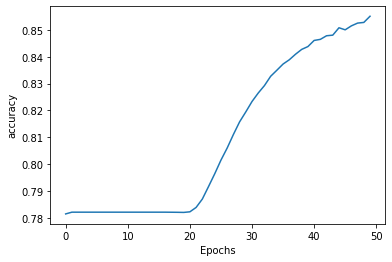

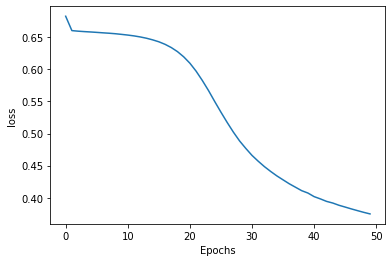

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  # plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  # plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(x_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
print(yhat_probs)
print(yhat_classes)

[[0.28407878 0.43587077 0.8126997 ]
 [0.1340161  0.3533389  0.9438994 ]
 [0.17173013 0.38692233 0.91273594]
 ...
 [0.18731049 0.46565467 0.8504069 ]
 [0.15752912 0.3707639  0.92697364]
 [0.05347627 0.33116746 0.97934806]]
[2 2 2 ... 2 2 2]


In [ ]:
# yhat_probs = yhat_probs[:, 0]
# yhat_classes = yhat_classes[:, 0]
print(yhat_probs)
print(yhat_classes)

[0.28407878 0.1340161  0.17173013 ... 0.18731049 0.15752912 0.05347627]
[2 2 2 ... 2 2 2]


In [39]:
from sklearn.metrics import precision_recall_fscore_support as score


In [ ]:
precision, recall, fscore, support = score(ytest, yhat_classes)

In [ ]:
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.71543659 0.39210526 0.80159421]
recall: [0.73925886 0.04763427 0.97253149]
fscore: [0.72715267 0.08494869 0.87882794]
support: [ 3724  3128 12305]


In [50]:
x_train.shape

(10500, 120)

In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [41]:
# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [51]:
num_epochs = 75

In [43]:
# Define the K-fold Cross Validator
num_folds = 4
kfold = KFold(n_splits=num_folds, shuffle=True)

In [48]:
# K-fold Cross Validation model evaluation
acc_per_fold_4 = []
loss_per_fold_4 = []
historys_fold_4 = []
f1scores = []
precisions = []
recalls = []

fold_no = 1
for train, test in kfold.split(inputs, targets):
  # Define the model architecture
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
  ])

  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              epochs=num_epochs,
              verbose=2)
  historys_fold_4.append(history)
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold_4.append(scores[1] * 100)
  loss_per_fold_4.append(scores[0])

  #METRIC CALCULATION
  y_pred = model.predict_classes(inputs[test], verbose=0)

  target = [np.where(r==1)[0][0] for r in targets[test]]

  f1scores.append(f1_score(target, y_pred, average="macro"))
  precisions.append(precision_score(target, y_pred, average="macro"))
  recalls.append(recall_score(target, y_pred, average="macro"))

  print(f1_score(target, y_pred, average="macro"))
  print(precision_score(target, y_pred, average="macro"))
  print(recall_score(target, y_pred, average="macro"))  

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/5
352/352 - 2s - loss: 1.0960 - accuracy: 0.3789
Epoch 2/5
352/352 - 1s - loss: 1.0929 - accuracy: 0.3867
Epoch 3/5
352/352 - 1s - loss: 1.0907 - accuracy: 0.3897
Epoch 4/5
352/352 - 1s - loss: 1.0892 - accuracy: 0.3898
Epoch 5/5
352/352 - 1s - loss: 1.0878 - accuracy: 0.3908
Score for fold 1: loss of 1.0905247926712036; accuracy of 37.6800000667572%


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.32341264154016053
0.3705748642539988
0.378076816007544
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/5
352/352 - 2s - loss: 1.0962 - accuracy: 0.3649
Epoch 2/5
352/352 - 1s - loss: 1.0927 - accuracy: 0.3891
Epoch 3/5


KeyboardInterrupt: ignored

In [ ]:
print(acc_per_fold_4)
print(loss_per_fold_4)

[54.26666736602783, 54.42666411399841, 58.160001039505005, 54.666668176651]
[1.0019840002059937, 0.9833484292030334, 0.9734342694282532, 0.9676955938339233]


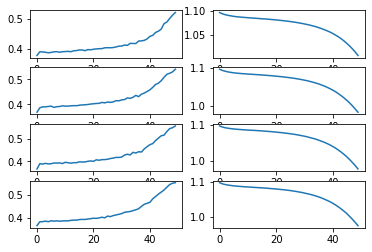

In [ ]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(4, 2)

axis[0, 0].plot(historys_fold_4[0].history['accuracy'])
axis[0, 1].plot(historys_fold_4[0].history['loss'])

axis[1, 0].plot(historys_fold_4[1].history['accuracy'])
axis[1, 1].plot(historys_fold_4[1].history['loss'])

axis[2, 0].plot(historys_fold_4[2].history['accuracy'])
axis[2, 1].plot(historys_fold_4[2].history['loss'])

axis[3, 0].plot(historys_fold_4[3].history['accuracy'])
axis[3, 1].plot(historys_fold_4[3].history['loss'])


plt.show()

In [ ]:
# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
acc_per_fold_5 = []
loss_per_fold_5 = []
historys_fold_5 = []
fold_no = 1
for train, test in kfold.split(inputs, targets):
  # Define the model architecture
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
  ])

  model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              epochs=num_epochs,
              validation_data=(inputs[test], targets[test]),
              verbose=2)
  historys_fold_5.append(history)
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold_5.append(scores[1] * 100)
  loss_per_fold_5.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
375/375 - 2s - loss: 1.0961 - accuracy: 0.3757 - val_loss: 1.0942 - val_accuracy: 0.3857
Epoch 2/50
375/375 - 2s - loss: 1.0935 - accuracy: 0.3871 - val_loss: 1.0918 - val_accuracy: 0.3853
Epoch 3/50
375/375 - 2s - loss: 1.0917 - accuracy: 0.3913 - val_loss: 1.0897 - val_accuracy: 0.3873
Epoch 4/50
375/375 - 2s - loss: 1.0902 - accuracy: 0.3929 - val_loss: 1.0884 - val_accuracy: 0.3857
Epoch 5/50
375/375 - 2s - loss: 1.0892 - accuracy: 0.3903 - val_loss: 1.0871 - val_accuracy: 0.3850
Epoch 6/50
375/375 - 2s - loss: 1.0883 - accuracy: 0.3893 - val_loss: 1.0861 - val_accuracy: 0.3900
Epoch 7/50
375/375 - 2s - loss: 1.0875 - accuracy: 0.3905 - val_loss: 1.0853 - val_accuracy: 0.3897
Epoch 8/50
375/375 - 2s - loss: 1.0868 - accuracy: 0.3924 - val_loss: 1.0848 - val_accuracy: 0.3847
Epoch 9/50
375/375 - 2s - loss: 1.0862 - accuracy: 0.3881 - val_loss: 1.0839 - val_accuracy: 0.3910
Epo

In [ ]:
print(acc_per_fold)
print(loss_per_fold)

[84.30820107460022, 83.71310234069824, 84.5744252204895, 85.09905338287354, 83.82928967475891]
[0.3863346576690674, 0.4024575650691986, 0.39687588810920715, 0.37228748202323914, 0.4231783449649811]


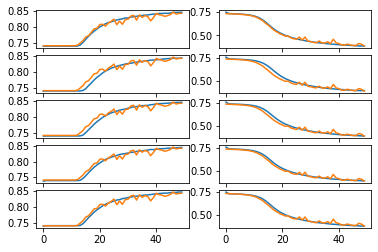

In [ ]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(5, 2)

def plot_graphs(history, string, axis):
  axis.plot(history.history[string])
  axis.plot(history.history['val_'+string])
  axis.xlabel("Epochs")
  axis.ylabel(string)
  axis.legend([string, 'val_'+string])

axis[0, 0].plot(historys[0].history['accuracy'])
axis[0, 1].plot(historys[0].history['loss'])
axis[0, 0].plot(historys[0].history['val_accuracy'])
axis[0, 1].plot(historys[0].history['val_loss'])

axis[1, 0].plot(historys[1].history['accuracy'])
axis[1, 1].plot(historys[1].history['loss'])
axis[1, 0].plot(historys[0].history['val_accuracy'])
axis[1, 1].plot(historys[0].history['val_loss'])

axis[2, 0].plot(historys[2].history['accuracy'])
axis[2, 1].plot(historys[2].history['loss'])
axis[2, 0].plot(historys[0].history['val_accuracy'])
axis[2, 1].plot(historys[0].history['val_loss'])

axis[3, 0].plot(historys[3].history['accuracy'])
axis[3, 1].plot(historys[3].history['loss'])
axis[3, 0].plot(historys[0].history['val_accuracy'])
axis[3, 1].plot(historys[0].history['val_loss'])

axis[4, 0].plot(historys[4].history['accuracy'])
axis[4, 1].plot(historys[4].history['loss'])
axis[4, 0].plot(historys[0].history['val_accuracy'])
axis[4, 1].plot(historys[0].history['val_loss'])

plt.show()

Gensim Word to Vector

In [ ]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(min_count=4,
                     window=4,
                     size=300,
                     workers=4)

In [ ]:
w2v_model.build_vocab(lemmatized_sentences)
w2v_model.train(lemmatized_sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)
w2v_model.init_sims(replace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


In [ ]:
w2v_model.most_similar('good')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('decent', 0.8235995173454285),
 ('great', 0.8140509128570557),
 ('excellent', 0.7423455715179443),
 ('ok', 0.6709718704223633),
 ('goodthe', 0.6623927354812622),
 ('nice', 0.6601988077163696),
 ('okay', 0.6420602798461914),
 ('awesome', 0.611646831035614),
 ('fantastic', 0.6071241497993469),
 ('greatthe', 0.5659160017967224)]

**Load Model**

In [ ]:
from gensim.models import KeyedVectors
w2v_model = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/Google Colab TA NLP/W2Vec Model/word2vec_lemmatiedSentences-min_count_4-window_4-size_300-workers_4.txt", binary=False)

**SAVE MODEL W2VECTOR**

In [ ]:
# w2v_model.save("/content/drive/MyDrive/Google Colab TA NLP/W2Vec Model/word2vec-min_count_4-window_4-size_100-workers_4.model")

In [ ]:
filename = "word2vec_lemmatiedSentences-min_count_4-window_4-size_300-workers_4.txt"
w2v_model.wv.save_word2vec_format(filename, binary=False)

In [ ]:
w2v_model.wv.vectors.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


(20441, 300)

In [ ]:
X = np.array()
for x in lemmatized_sentences : 
  vec = [list(w2v_model.wv.get_vector(s)) for s in x[:10] if s in w2v_model.wv.vocab.keys()]
  sen = [s for s in x[:10] if s in w2v_model.wv.vocab.keys()]
  print(vec)
  print(sen)
  X.append(np.asarray(vec))
  break

TypeError: ignored

In [ ]:
X.shape

AttributeError: ignored

In [ ]:
X = []
for x in lemmatized_sentences : 
  vec = [list(w2v_model.wv.get_vector(s)) for s in x if s in w2v_model.wv.vocab.keys()]
  X.append(np.asarray(vec))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
x_train = np.asarray(X)
x_train.shape

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(63854,)

In [ ]:
X = np.array(X)
X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


(63854,)

In [ ]:
X[0]

array([[ 0.02749318, -0.00618919,  0.00711035, ...,  0.0500071 ,
         0.06482694, -0.03189293],
       [ 0.05109973, -0.00441204,  0.00655634, ...,  0.0507033 ,
        -0.1463205 ,  0.05049113],
       [ 0.11189305, -0.1294035 , -0.01876633, ...,  0.02341644,
        -0.09739904, -0.00475801],
       ...,
       [ 0.08268816,  0.07149787, -0.0302761 , ..., -0.05564751,
         0.01434718, -0.04557393],
       [ 0.11189305, -0.1294035 , -0.01876633, ...,  0.02341644,
        -0.09739904, -0.00475801],
       [ 0.0087229 ,  0.06140604,  0.00147489, ...,  0.02358435,
         0.07426417, -0.04531777]], dtype=float32)

In [ ]:
Y = label_encoder(labels)
Y.shape

(63854, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = split_data(X, Y)

In [ ]:
word_index, X_train, X_test = Tokenization(X_train, X_test)

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(44697,)
(44697, 3)
(19157,)
(19157, 3)


In [ ]:
X_train[0]

In [ ]:
X_train

In [ ]:
model_ANN = tf.keras.Sequential([
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='sigmoid')
])
model_ANN.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

In [ ]:
model_ANN.build(input_shape=(44697, 300))

In [ ]:
model_ANN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (44697, 300)              90300     
_________________________________________________________________
dense_5 (Dense)              (44697, 120)              36120     
_________________________________________________________________
dense_6 (Dense)              (44697, 64)               7744      
_________________________________________________________________
dense_7 (Dense)              (44697, 3)                195       
Total params: 134,359
Trainable params: 134,359
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 50
history = model_ANN.fit(X_train, Y_train, epochs=num_epochs,
                        validation_data=(X_test, Y_test),
                        verbose=2)

ValueError: ignored

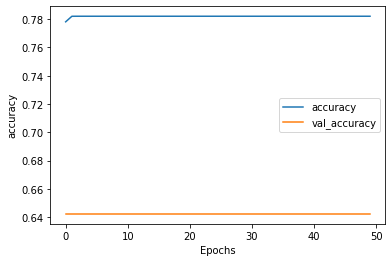

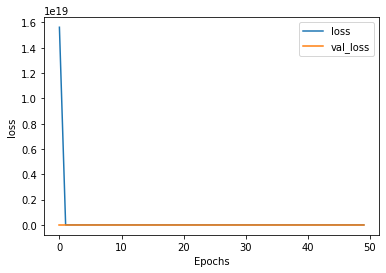

In [ ]:

import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
sentence = "this hotel really bad"
lemmatizer = WordNetLemmatizer()
t = lemmatizer.lemmatize(sentence)
print(t)
t = t.split()
filtered_sentence = [w for w in t if not w in stop_words]
filtered_sentence

this hotel really bad


['hotel', 'really', 'bad']

In [ ]:
Test = [w2v_model.wv.word_vec(x) for x in filtered_sentence]
Test = np.asarray(Test)
Test.shape

(3, 100)

In [ ]:
padded = pad_sequences(filtered_sentence, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded

ValueError: ignored

In [ ]:
padded = pad_sequences(Test, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model_ANN.predict(padded))

[[0.34846032 0.33457276 0.78808135]
 [0.34846032 0.33457276 0.78808135]
 [0.34846032 0.33457276 0.78808135]]


In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(n_splits=4, shuffle=True)